# Schedulability, Roll Angles, Backgrounds

* Available roll angles and Background vs. observation date
    - Similar to the Roll Range reports plotted by APT but with background information added.
* Background Limited Special Requirement in APT
    - Can restrict observations to be performed when background is within 10%, 20%, 40%, or 80% of mininum
    - Note APT checks the backgrounds for all filters in your observation. Say you restrict backgrounds to within 10% of minimum. If you add a redder filter like F444W, the backgrounds will vary more, and fewer days will be available.
    - We calculate how many days would be available at each of these thresholds.

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('http://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import numpy as np
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from jwst_backgrounds import jbt 

In [55]:
#import sys
#stdout = sys.stdout

import datetime
from jwst_gtvt import find_tgt_info

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import norm

import matplotlib.dates as mdates
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
#months_fmt = mdates.DateFormatter('%b1') # explicitly label each tick as the first day of the month
months_fmt = mdates.DateFormatter('%b')
year = 2022  # results don't vary much from one year to the next

In [48]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#cmap = mpl.cm.plasma
# Define a new colormap with sharp transitions at percentiles 10%, 20%, 40%, 80%
cmap = cm.get_cmap('plasma', 10)
newcolors = cmap(range(10))
newcolors[1] = newcolors[2]
newcolors[2:4] = newcolors[4]
newcolors[4:8] = newcolors[6]
newcolors[8:] = newcolors[8]

newcmap = ListedColormap(newcolors)
cmap = newcmap

In [52]:
def roll_report(target, ra_str, dec_str, lam=4.5, save_plot=False, show_plot=True):
    """Plot available roll angles and backgrounds vs. observation date"""

    # Backgrounds
    ra_dec_str = ra_str + ' ' + dec_str
    c = SkyCoord(ra_dec_str, unit=(u.hourangle, u.deg))
    ra_deg = c.ra.value
    dec_deg = c.dec.value
    
    #stdout = sys.stdout
    #sys.stdout = open('/dev/stdout', 'w')  # Send output to terminal window; don't show here in notebook
    bkg = jbt.background(ra_deg, dec_deg, wavelength=4.5, thresh=1.1)
    #sys.stdout = stdout
    
    calendar = bkg.bkg_data['calendar']
    bkgtot = bkg.bkg_data['total_bg']
    lams = bkg.bkg_data['wave_array']
    tt = [datetime.date(year, 1, 1) + datetime.timedelta(days=int(d1)) for d1 in calendar]
    tt = np.array(tt)
    
    i = lams.searchsorted(lam)
    bg = bkgtot[:,i]

    # Visibility
    ra_str2 = ra_str.replace(' ', ':')
    dec_str2 = dec_str.replace(' ', ':')
    dec_str2 = dec_str2.replace('+', '')
    tbl = find_tgt_info.get_table(ra_str2, dec_str2)

    ttv = [x.date() for x in tbl['Date']]
    ttv = np.array(ttv)

    itt = tt - ttv[0]
    itt = [x.days for x in itt]
    dates = ttv[itt]
    V3PAmin = tbl['V3PA min'][itt]
    V3PAmax = tbl['V3PA max'][itt]

    x = dates
    dx = x[1] - x[0]
    ymin = V3PAmin
    ymax = V3PAmax
    z = bg
    vmin = z.min()
    vmax = 2.0 * vmin
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    bgmin = min(bg)
    bgmax = max(bg)

    fig = plt.figure(figsize=(9.5,5))
    ax = fig.add_axes([0.12, 0.15, 0.68, 0.78])

    # Oversample the roll angles by 10 for a smoother plot
    bg_array = np.empty((10*360, 366), dtype=float)  # roll, day
    bg_array[:] = np.NaN
    
    t0 = datetime.date(year,   1, 1)
    t1 = datetime.date(year+1, 1, 1)
    ttyear = [t0 + datetime.timedelta(days=int(d1)) for d1 in range(366)]

    i = -1
    for iday, day in enumerate(ttyear):
        if day not in tt:
            continue
        
        i += 1
        ylo = ymin[i]
        yhi = ymax[i]
        if not np.isnan(yhi):
            if yhi > ylo:
                bg_array[int(10*ylo):int(10*yhi), iday] = z[i]
            else:
                bg_array[:int(10*yhi), iday] = z[i]
                bg_array[int(10*ylo):, iday] = z[i]
    
    extent = mdates.date2num(t0), mdates.date2num(t1), 0, 360
    plt.imshow(bg_array, extent=extent, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.fmt_xdata = mdates.DateFormatter('%b %d')  # Format cursor hover

    plt.xlabel('Observation Date')
    plt.ylabel('Roll Position Angle (PA) (deg)')

    plt.xlim(t0, t1)
    plt.ylim(0, 360)    

    title = target
    title += '  (%s, %s)' % (ra_str, dec_str)
    title += '  (%.5f, %.5f)' % (ra_deg, dec_deg)
    plt.title(title, fontsize=14)

    # Colorbar
    cbax = fig.add_axes([0.84, 0.15, 0.03, 0.78])
    bg_threshs = np.array([1.0, 1.1, 1.2, 1.4, 1.8, 2.0])
    ticks = bg_threshs * vmin
    ticks = list(ticks)
    ticks.append(bgmax)
    
    mpl.colors.Normalize(clip=False)
    cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, ticks=ticks, norm=normalize, orientation='vertical')

    cb.set_label("Background (MJy/sr) @ %g $\mu$m" % lam, rotation=270, labelpad=20)

    ctick_labels = ['%.3f' % vmin]
    for bg_thresh in bg_threshs[1:]:
        thresh_percent = (bg_thresh - 1) * 100
        thresh_percent += 1e-8
        label = '+%d%%' % thresh_percent
        ctick_labels.append(label)
    
    ctick_labels.append('Max')
        
    cb.ax.set_yticklabels(ctick_labels)

    if save_plot:
        target = target.replace(' ', '')
        plt.savefig('schedulability_%s.png' % target, dpi=200)
    
    if show_plot:
        plt.show()
    
    return bg_array

<IPython.core.display.Javascript object>


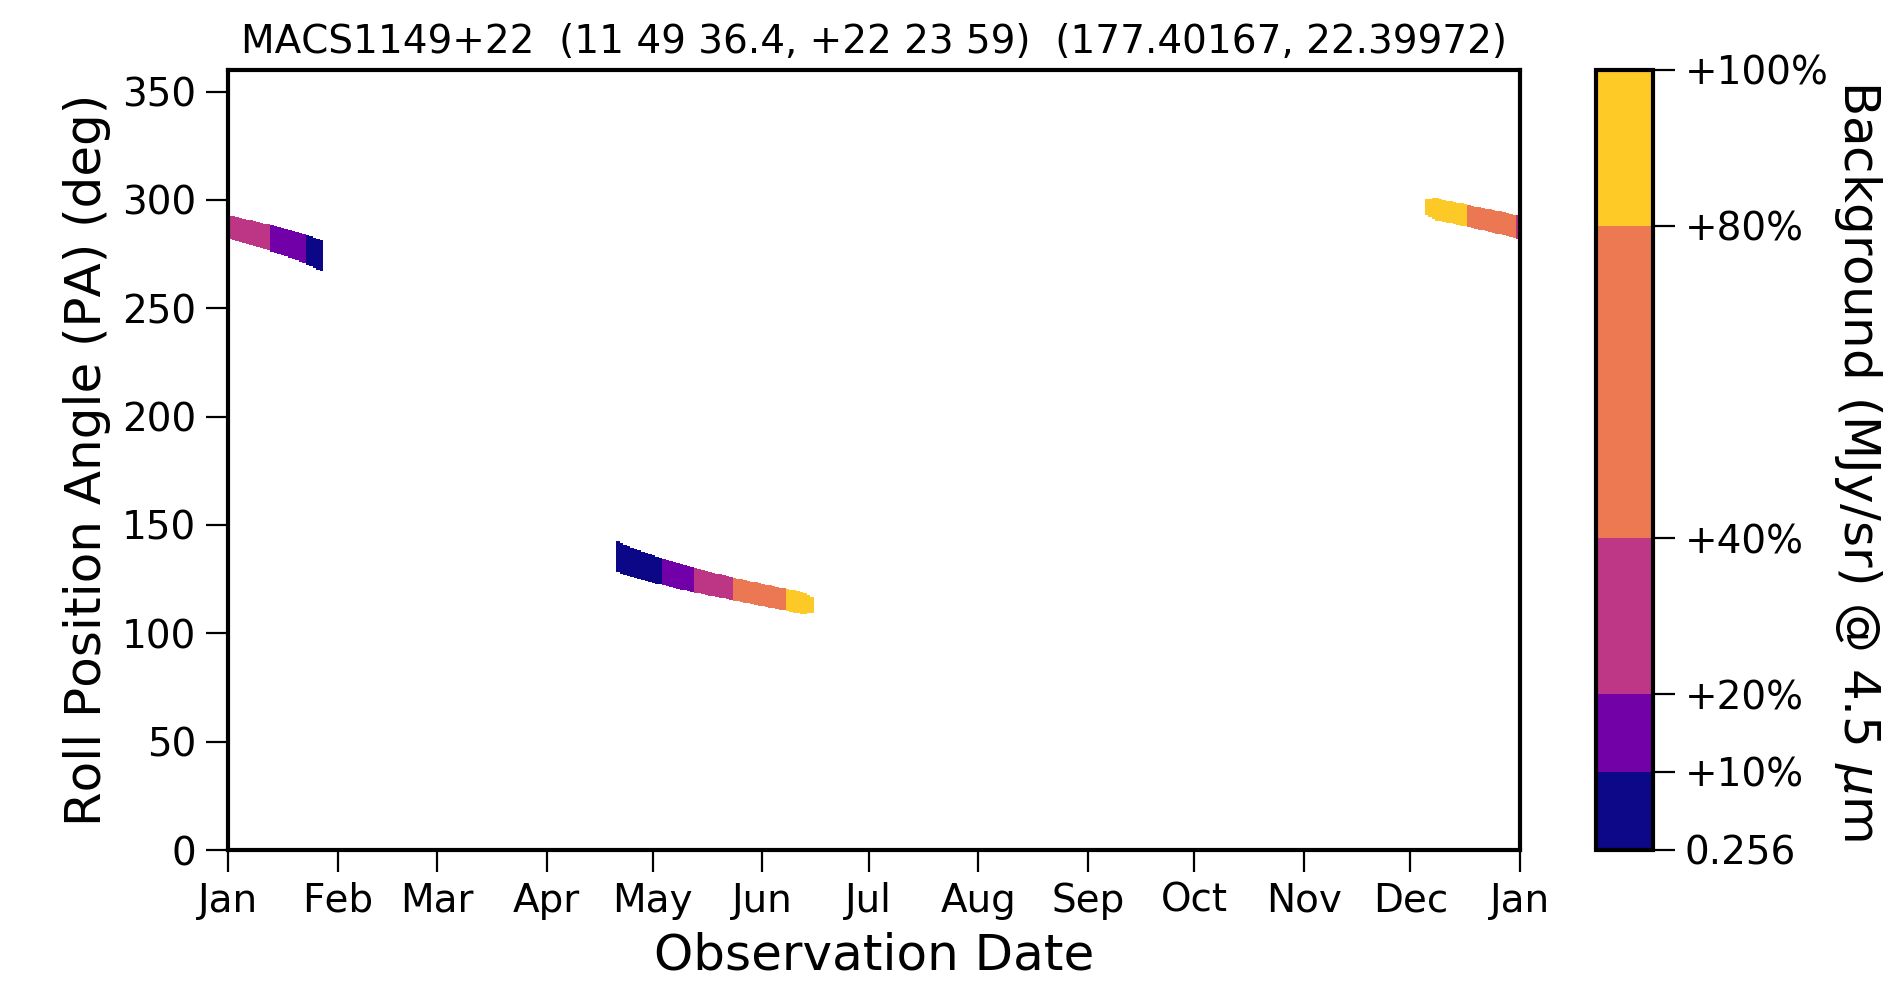

In [56]:
# Plot available roll angles and backgrounds vs. observation date
bg_array = roll_report('MACS1149+22', '11 49 36.4', '+22 23 59', lam=4.5)

<IPython.core.display.Javascript object>


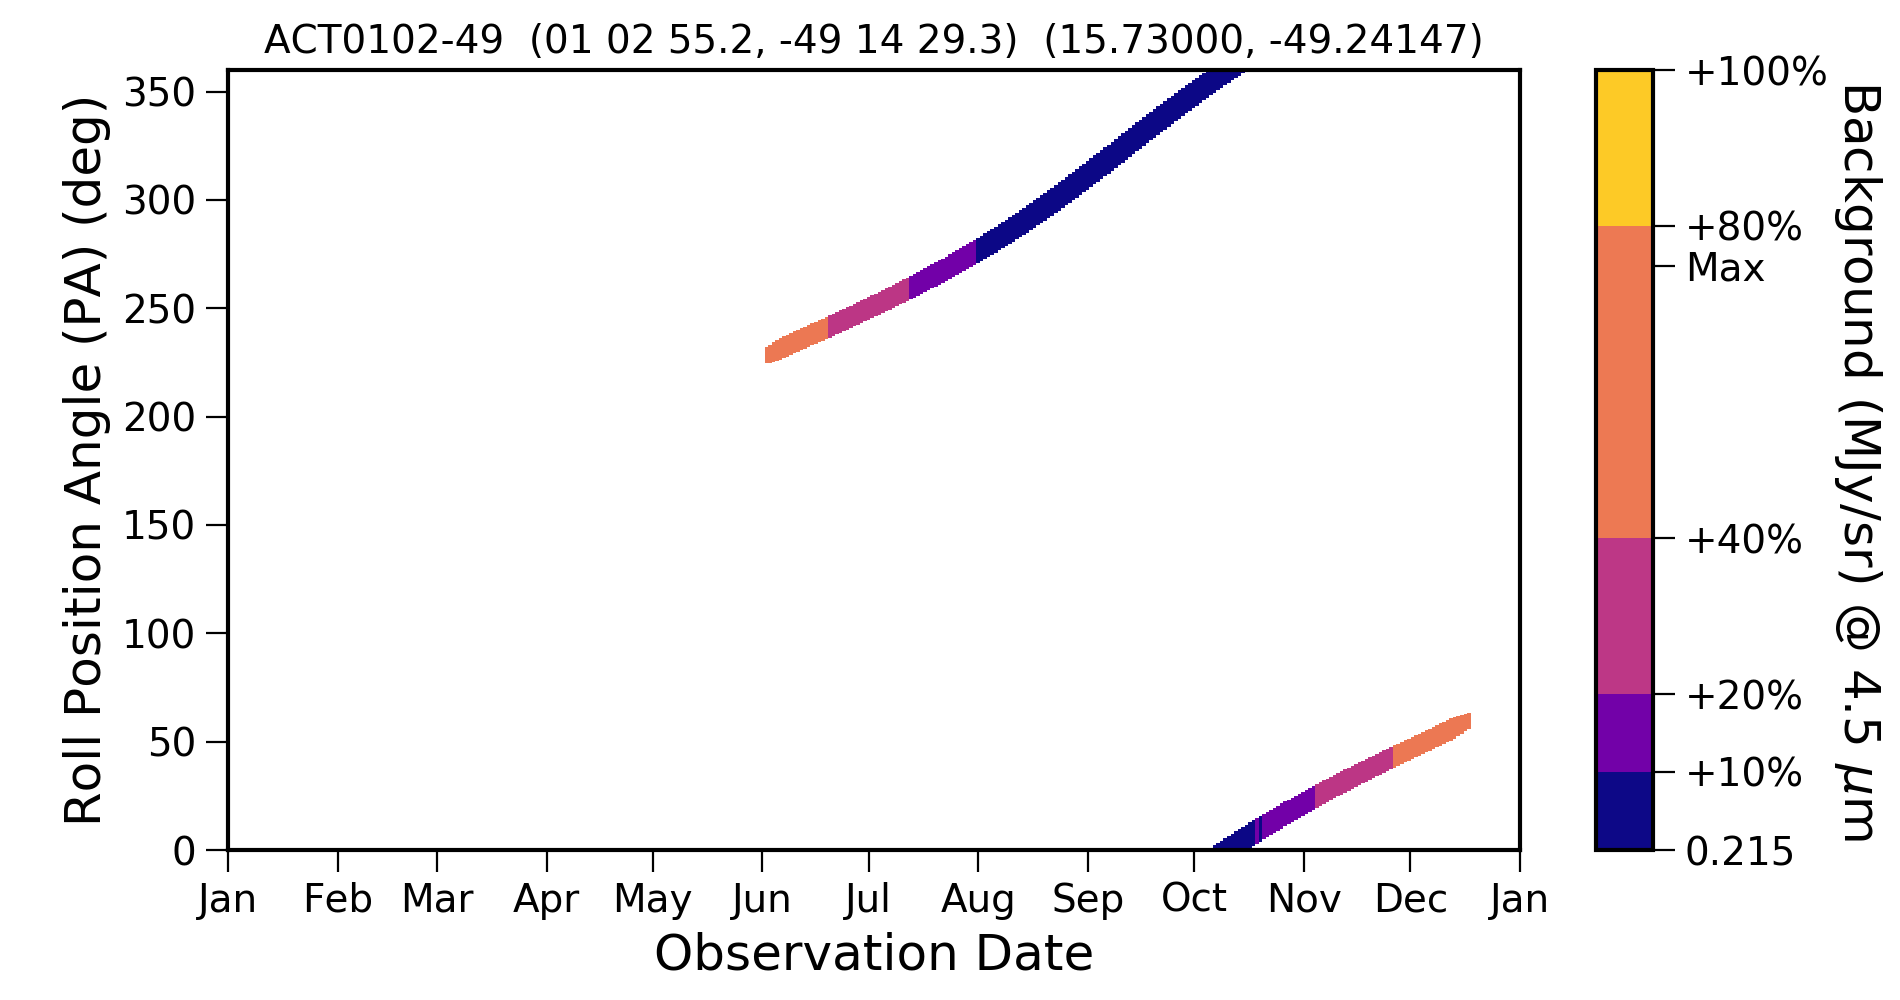

In [63]:
# Plot available roll angles and backgrounds vs. observation date
bg_array = roll_report('ACT0102-49', '01 02 55.2', '-49 14 29.3', lam=4.5)  # El Gordo

In [64]:
# Summary of observable days & angles for different background thresholds

s = '\n'
for thresh in 10, 1.8, 1.4, 1.2, 1.1:
    bg_days = np.nanmin(bg_array, axis=0)
    good_days = bg_days < thresh * np.nanmin(bg_days)

    bg_rolls = np.nanmin(bg_array, axis=1)
    good_rolls = bg_rolls < thresh * np.nanmin(bg_rolls)
    s+= '%3d days / year (%3d / 360 degrees)' % (np.sum(good_days), np.sum(good_rolls)//10)
    if thresh < 2:
        s += ' below %g x min background\n' % thresh
    else:
        s += ' schedulable\n'

print(s)  # Output will show up in terminal